# Advanced Lane Finding Project (Finding Lane line / Warp image Part3)

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## TestImage Pipeline ##

In [1]:
import cv2
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import mean_squared_error

import pickle
import sys

import os
import pandas as pd
import matplotlib.gridspec as gridspec

import seaborn as sns

from PIL import Image
from skimage.transform import rescale, resize, rotate
from skimage.color import gray2rgb, rgb2gray
from skimage import transform, filters, exposure
from skimage.io import imread, imsave

from scipy.ndimage.interpolation import rotate

from utils import hls_threshold
from utils import applyCombinedGradient


from utils import showImageList
from utils import pipelineBinaryImage
from utils import pipelineBinaryImage2
from utils import pipelineBinaryImage3
from utils import pipelineBinaryImage4

import platform

%matplotlib inline


***
##   pipelineBinaryImage definition 
***
* normal image to sobelx   
* S channel of HLS binary filtering. 
* then make binary including those 2 categorical mask 

***
##   pipelineBinaryImage2 definition 
***
* l channel of HLS applied to sobelx  
* S channel of HLS binary filtering. 
* then make binary including those 2 categorical mask

### common function to set threshhold values ###

## load saved pickle camera calibration parameters ##

In [2]:
# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "./pickled_data/calibration.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]


# Load Test images and undistortion images from saved directory #

In [3]:
#
# load test images from test_images directory
#
# read with skimage.io.imread (RGB mode)

filenames = sorted( os.listdir("./test_images/") )
images = list( map( lambda x: imread( os.path.join("./test_images",x)), filenames) )

#undistort_filenames = sorted( os.listdir("./undistort/") )
#undistort_images = list( map( lambda x: imread( os.path.join("./undistort",x)), filenames) )

undist_ops = lambda img:cv2.undistort(img, mtx, dist, None, mtx)
undist_images = list( map( undist_ops, images ) )

gray_ops = lambda im:cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
undist_gray_images = list( map( gray_ops, undist_images ) )


## Check Binary and Color Image  

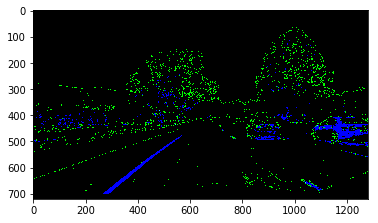

In [4]:
c, b = pipelineBinaryImage4(undist_images[2])
plt.imshow(c)

## Draw the rectange lines for indentifying the lane lines on the road ##

* for the reference 

In [5]:
#
# Definition of 
# Src and Dst
#
# Hardcoded data points for Perspective window 

src = np.float32([[270,674],
                 [579,460],
                 [702,460],
                 [1060,674]])
dst = np.float32([[270,674],
                 [270,0],
                 [1035,0],
                 [1035,674]])

In [6]:
def M_gen(src,dst):
    
    # Given src and dst points, calculate the perspective transform matrix
    # source is 4 points trapezoid
    # destination is 4 points rectangle
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv

def warp_gen(img,M):
    # check out the image shape
    img_size = ( img.shape[1], img.shape[0] )
    warped = cv2.warpPerspective(img, M, img_size)
    # Return the resulting image and matrix
    return warped

def undistort_corners(img, mtx, dist):

    # images should be undistortion based on camera calibration.
    # incoming image is RGB format --> skimage.io.imread
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

In [7]:
M, Minv = M_gen(src,dst)

#### Source is common parameter for all of incoming test images 

In [8]:
def drawTapezoidPolygon(image,src):
    
    copy_image = np.copy(image)
    red = (255,0,0)
    pts = src.astype(np.int32).reshape((-1,1,2))
    polygon_image = cv2.polylines(copy_image ,[pts],True, red, thickness=3)
    return polygon_image


In [9]:
draw_ops = lambda im:drawTapezoidPolygon(im,src)
draw_images = list( map( draw_ops,undist_images ) )
draw_labels = list(map( lambda x:"cropped "+x , filenames ))

#draw_images_list =  np.asarray(list( zip(undist_images,draw_images) ))
#draw_images_label =  np.asarray(list( zip(filenames,draw_labels) ))

In [135]:
def makeWarpViewBinaryImage(image,src,dst,mtx,dist):
    
    M, Minv = M_gen(src,dst)
    undist = undistort_corners(image, mtx, dist)
    warp_image = warp_gen(undist,M)
    _, warp_binary = pipelineBinaryImage4(warp_image)
    
    return warp_binary

In [10]:
def makeBirdViewImages(images,src,dst,mtx,dist):
    #
    # input images --> normal images
    #
    warped_images = []
    for im in images:
        M, Minv = M_gen(src,dst)
        undist = undistort_corners(im, mtx, dist)
        warp_image = warp_gen(undist,M)
        warped_images.append(warp_image)
        
    return warped_images

In [11]:
def variance_of_laplacian(image):
    # compute the Laplacian of the image and then return the focus
    # measure, which is simply the variance of the Laplacian
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return cv2.Laplacian(gray, cv2.CV_64F).var()

laplacian_ops = lambda im:variance_of_laplacian(im)

def sharpen_image(image):
    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    #gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = cv2.filter2D(image, -1, kernel)
    return image

sharpen_image_ops = lambda im:sharpen_image(im)

In [12]:
# input is RGB image
warped_images = makeBirdViewImages(images,src,dst,mtx,dist)

In [13]:
warp_images_list =  np.asarray(list( zip(undist_images,draw_images,warped_images) ))
warp_labels = list(map( lambda x:"warped "+x , filenames ))
warp_images_label =  np.asarray(list( zip(filenames,draw_labels,warp_labels) ))

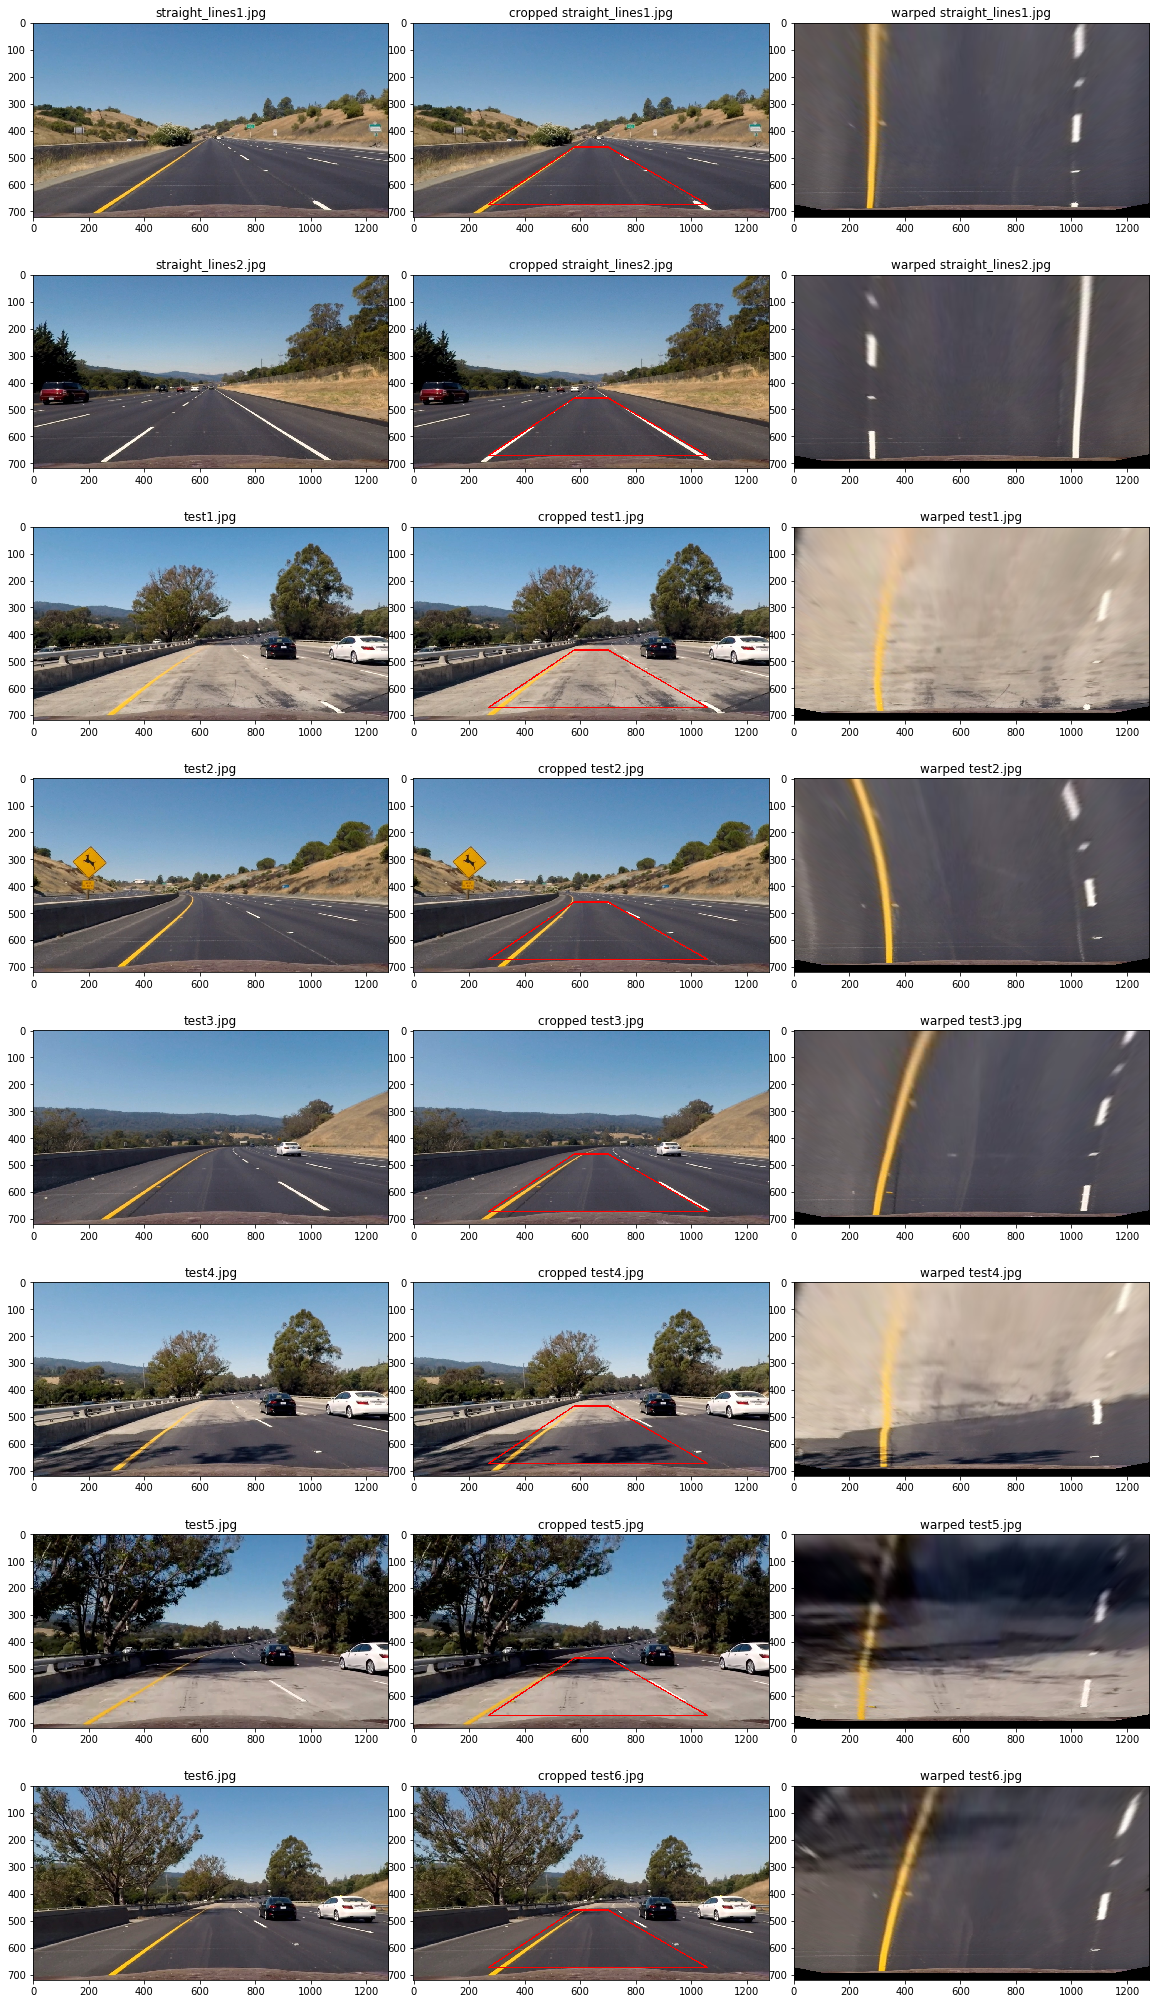

In [14]:
showImageList(warp_images_list, warp_images_label,cols=3,fig_size=(20, 36) )

## Check Laplacian Filter of Warped Images ##

In [16]:
warp_image_variance_of_laplacian =  list(map(laplacian_ops,warped_images))
print(warp_image_variance_of_laplacian)

# for reference of normal image
undist_image_variance_of_laplacian =  list(map(laplacian_ops,undist_images))
print(undist_image_variance_of_laplacian)

[39.798980001491969, 37.817390400261338, 54.903598777911107, 39.819570301192492, 39.122753903066368, 47.440901448962137, 42.324005147976337, 40.274308789937294]
[63.895242617454038, 90.715437719037794, 129.28678662561367, 64.305710476739876, 55.049687853961508, 132.15273612424002, 177.50480454312418, 204.41613618634557]


***
* After checking out how warped images are blurred with transformation process of warping from original tapezoid crop area, 
most of laplacian values are lower than original.
* If we apply sharpen warped images, it would be easy for extraction program to recognize the displayed lines as lane lines.

In [15]:
def makePipelineColoredBinaryImages(images):

    colored_lane_images = []
    binary_lane_images = []
    for im in images:
        
        # 
        # pipelineBinaryImage4 is used for making binary image
        #
        binary_ops4 = lambda im:pipelineBinaryImage4(im)
        c , b = binary_ops4(im)
        
        colored_lane_images.append(c)
        binary_lane_images.append(b)
    
    return colored_lane_images, binary_lane_images

colored_lane_images, binary_lane_images = makePipelineColoredBinaryImages(warped_images)

In [16]:
warped_gray_images = list(map(gray_ops,warped_images))

binary_images_list =  np.asarray(list( zip(warped_gray_images,binary_lane_images) ))
binary_labels = list(map( lambda x:"Gradient Pipeline "+x , filenames ))
binary_images_label =  np.asarray(list( zip(filenames,binary_labels) ))

## Comaparison image Warped Gray Image and Binary / Colored Integrated Image

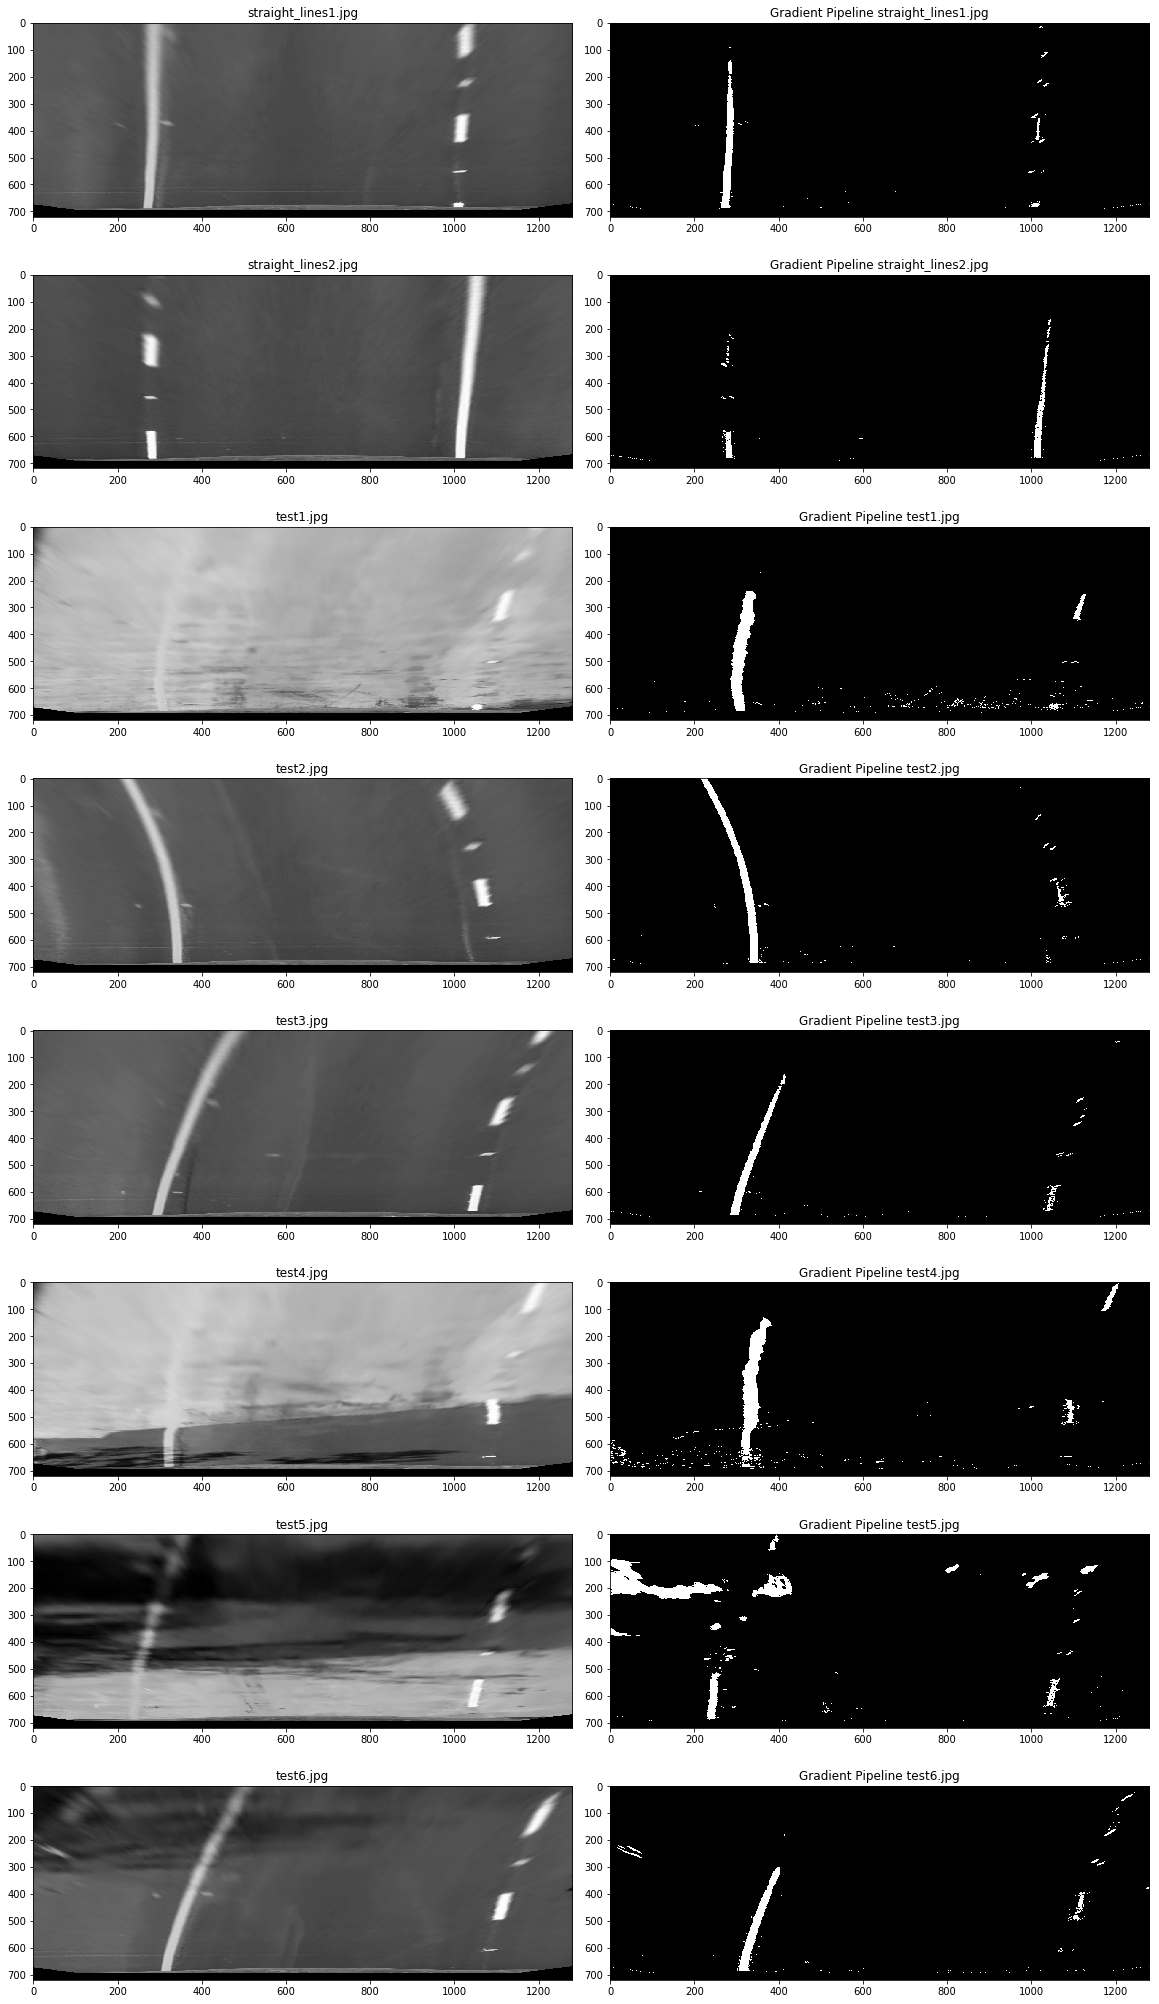

In [17]:
showImageList(binary_images_list, binary_images_label,cols=2,fig_size=(20, 36) )

### Check histogram of binary image axis=0 (x) from half size of image ###

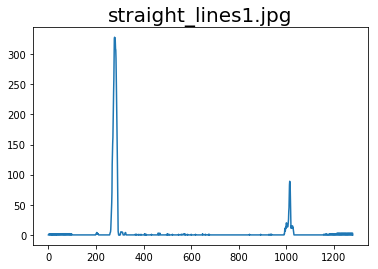

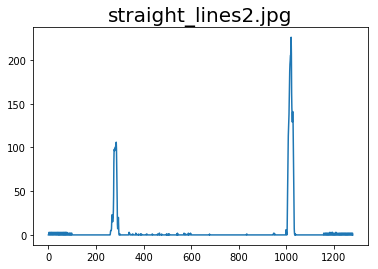

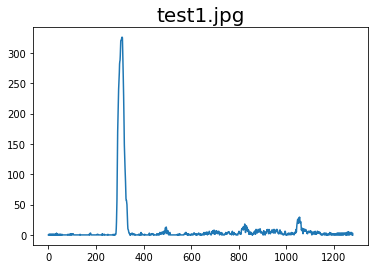

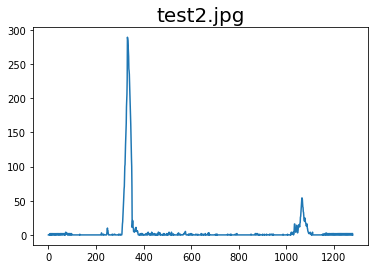

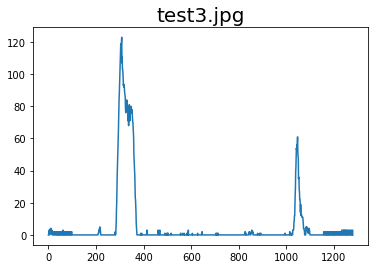

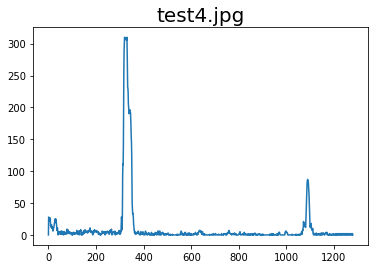

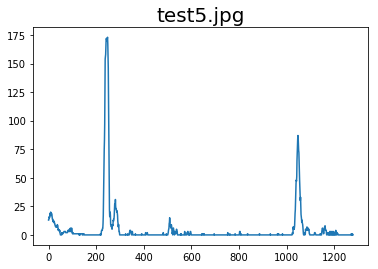

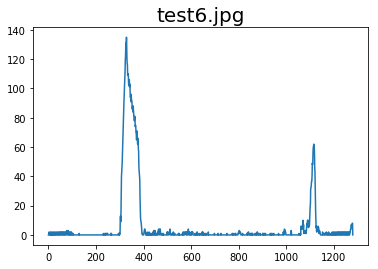

In [18]:
def checkHistograms(filenames,images):
    for f , im in zip(filenames,images):
        histogram1 = np.sum(im[  im.shape[0]//2:,:  ], axis=0)
        plt.plot(histogram1)
        plt.title(f,fontsize=20)
        plt.show()
checkHistograms(filenames,binary_lane_images)

Calculated Center - TopLeft - TopRight
* 640 278 1014
* 640 285 1020
* 640 309 1054
* 640 332 1065
* 640 308 1047
* 640 320 1089
* 640 248 1048
* 640 328 1115

In [108]:
def searchinglaneline(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    #print(histogram)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    
    # Choose the number of sliding windows
    nwindows = 9
    #
    # Set height of windows = 720 / 9 = 80px
    # It should be constant if we read video format.
    #
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    #print("window hight --> %spx " %window_height)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base    
    
    # Set the width of the windows +/- margin
    margin = 100 # px
    # Set minimum number of pixels found to recenter window
    minpix = 50 # 
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    
    for i, window in enumerate(range(nwindows)):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # for debug
        #print(i,  win_xleft_low,win_xleft_high,win_xright_low,win_xright_high, win_y_low, win_y_high)
        # Draw the windows on the visualization image
        GREEN_C = (0,255,0)
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),GREEN_C, 4) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),GREEN_C, 4) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    # Concatenate the arrays of indices to make flat array
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    return out_img,midpoint,leftx_base,rightx_base,leftx,lefty,rightx,righty


def foundlaneline(binary_warped,left_fit,right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()

    # count nonzero y and nonzero x
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100 # px

    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    minpix = 50 # 
    
    #print("left lane found px counter:", len(left_lane_inds) )
    #print("right lane found px counter:", len(right_lane_inds) )
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    return leftx,lefty,rightx,righty

## Radius of Curvature ##


***

* Math Formulation is as follows
* A or B is fitting parameters. 
 $$R_{curve} = \frac{ (1 + (2Ay + B)^2) ^\frac{3}{2}  }{ |2A| } $$



In [109]:
def formula2(a, b, c, y):
    
    x = a * y ** 2 + b * y + c
    return x 

def fitting(lefty,leftx,righty,rightx):

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return left_fit,right_fit

def fitXY(ploty,left_fit,right_fit):
    
    print("fitXY - left fit:",left_fit)
    print("fitXY - right fit:",right_fit)    
    
    #left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    #right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    a, b, c = left_fit
    left_fitx = formula2(a, b, c, ploty)
    
    a, b, c = right_fit
    right_fitx = formula2(a, b, c, ploty)
    
    return left_fitx,right_fitx

def curvature(ploty, left_fitx, right_fitx):

    # 
    # This logic can be used for sanitary check polyfit calculation.
    #
    y_eval = np.max(ploty)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720.0 # meters per pixel in y dimension
    xm_per_pix = 3.7/700.0 # meters per pixel in x dimension
    
    lefty = ploty*ym_per_pix
    leftx = left_fitx*xm_per_pix
    righty = ploty*ym_per_pix
    rightx = right_fitx*xm_per_pix
    
    left_fit_cr, right_fit_cr = fitting(lefty,leftx,righty,rightx)
    #left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    #right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)    
    # Calculate the new radii of curvature
    a, b, c = left_fit_cr
    left_curverad = ((1 + (2*a*y_eval*ym_per_pix + b)**2)**1.5) / np.absolute(2*a)
    
    a, b, c = right_fit_cr
    right_curverad = ((1 + (2*a*y_eval*ym_per_pix + b)**2)**1.5) / np.absolute(2*a)
    # Now our radius of curvature is in meters
    print("Curvature result")
    print(left_curverad, 'm', right_curverad, 'm')

In [110]:
def displyIntegrateView(out_img,ploty,left_fitx,right_fitx):

    plt.figure(figsize=(10,8))
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    #plt.title("Curved Line1",fontsize="22")
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.show()
    

In [117]:
def genResultImageAfterFitting(binary_warped, ploty, left_fit,right_fit):

    #
    # left_fit & right_fit ==> calculated with fitting method
    #
    
    leftx,lefty,rightx,righty = foundlaneline(im,left_fit,right_fit)
    left_fit_new,right_fit_new = fitting(lefty,leftx,righty,rightx)
    left_fitx,right_fitx = fitXY(ploty,left_fit_new,right_fit_new)
    
    #
    # This is called after fitting parameters searched with fitting function
    #
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
        
    out_img[lefty,leftx] = [255,0,0] # LEFT RED
    out_img[righty,rightx] = [0,0,255] # RIGHT BLUE
    
    # Color in left and right line pixels
    #out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    #out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    margin = 100
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    #displyIntegrateView(result,ploty,left_fitx,right_fitx)

    return result, left_fitx, right_fitx

In [125]:
def drawPolygonZoneOnLane(image, result, ploty, left_fitx, right_fitx, Minv):
    
    # %% Warp the detected lane boundaries back onto the original image
    # # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(result, np.int_([pts]), (0,255, 0))    
    
    img_size = ( result.shape[1], result.shape[0] )
    newwarp = cv2.warpPerspective(result, Minv, (img_size[0], img_size[1])) 
    newwarp = np.uint8(newwarp)
        
    # Combine the result with the original image
    final = cv2.addWeighted(image, 1, newwarp, 0.5, 0)
    plt.figure(figsize=(10,8))
    plt.imshow(final)
    plt.show()

<straight_lines1.jpg>
fitXY - left fit: [ -6.77404979e-05   3.51782406e-02   2.80056631e+02]
fitXY - right fit: [  3.68893818e-06  -3.80564717e-02   1.03006310e+03]
fitXY - left fit: [  1.72655901e-04  -3.90661360e-01   5.00188940e+02]
fitXY - right fit: [ -1.06772507e-03   8.81781246e-01   9.28025938e+02]
Curvature result
951.64485339 m 155.398793186 m


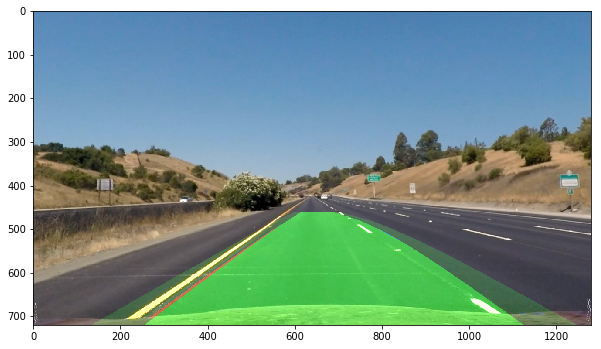

<straight_lines2.jpg>
fitXY - left fit: [  1.26428159e-04  -1.09194161e-01   2.99670502e+02]
fitXY - right fit: [  1.46130834e-05  -7.56672855e-02   1.05492452e+03]
fitXY - left fit: [  1.76027192e-04  -3.92387882e-01   4.99967058e+02]
fitXY - right fit: [ -6.78632448e-04   4.56878227e-01   1.04327458e+03]
Curvature result
933.39905068 m 243.571741707 m


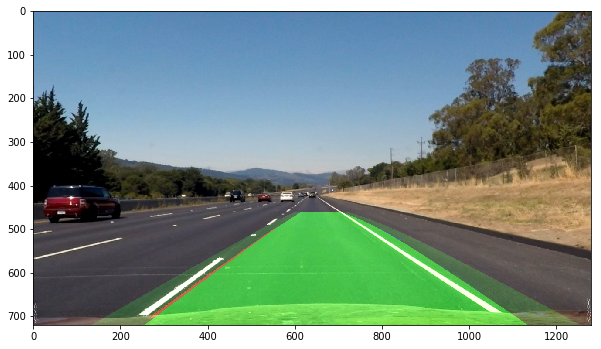

<test1.jpg>
fitXY - left fit: [  3.01599375e-04  -3.53554087e-01   4.06512830e+02]
fitXY - right fit: [  1.84506518e-04  -3.54006845e-01   1.20312480e+03]
fitXY - left fit: [  1.70804552e-04  -3.91780582e-01   5.01707405e+02]
fitXY - right fit: [  1.05224093e-04  -3.28340816e-01   1.23754591e+03]
Curvature result
961.985055979 m 1561.91396277 m


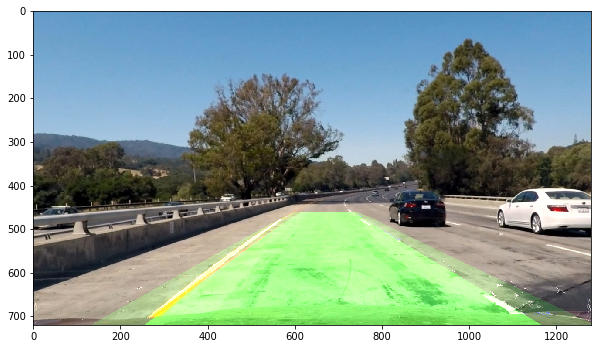

<test2.jpg>
fitXY - left fit: [ -2.75837940e-04   3.64639142e-01   2.22260165e+02]
fitXY - right fit: [ -4.84242656e-04   4.72795180e-01   9.54189855e+02]
fitXY - left fit: [  2.64857141e-04  -4.84302880e-01   5.23640147e+02]
fitXY - right fit: [ -9.30216191e-06  -1.95180110e-01   1.20053615e+03]
Curvature result
620.217916472 m 17673.2235534 m


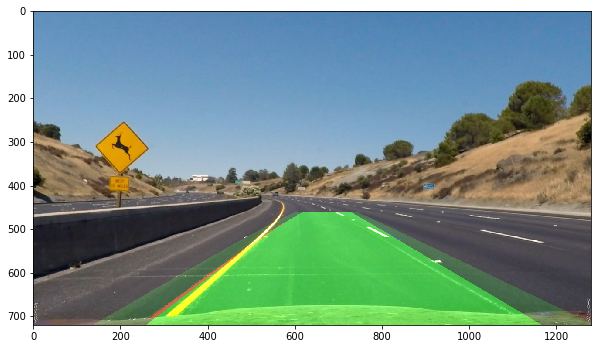

<test3.jpg>
fitXY - left fit: [  1.22753445e-04  -3.43207635e-01   4.70570565e+02]
fitXY - right fit: [  1.85861616e-04  -3.81503531e-01   1.21160181e+03]
fitXY - left fit: [  1.65602195e-04  -3.87057710e-01   5.00682399e+02]
fitXY - right fit: [  9.29181899e-05  -3.21689521e-01   1.23697311e+03]
Curvature result
992.225094626 m 1768.94287032 m


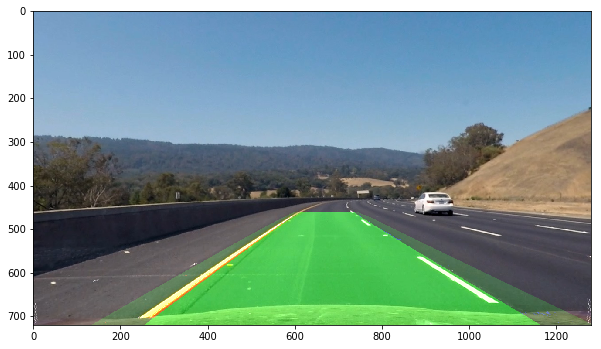

<test4.jpg>
fitXY - left fit: [  1.34501928e-04  -1.78779306e-01   3.83401691e+02]
fitXY - right fit: [  5.06092614e-04  -5.03653956e-01   1.21274546e+03]
fitXY - left fit: [  1.88757455e-04  -4.08026577e-01   5.05223545e+02]
fitXY - right fit: [  3.18115744e-04  -4.42632433e-01   1.24729679e+03]
Curvature result
870.432889947 m 516.251082662 m


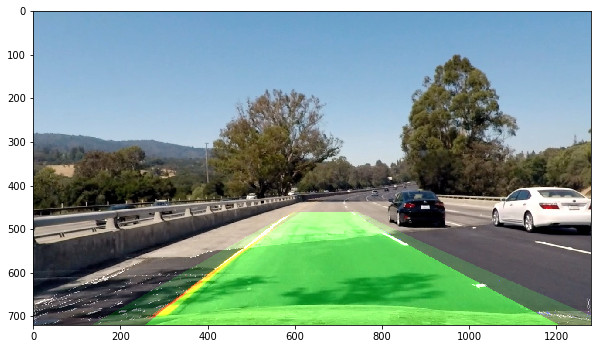

<test5.jpg>
fitXY - left fit: [  4.94350194e-04  -5.31374998e-01   3.85553231e+02]
fitXY - right fit: [  1.46641061e-05  -8.41916620e-02   1.09442192e+03]
fitXY - left fit: [ -1.55681847e-04   4.06417528e-02   3.58934405e+02]
fitXY - right fit: [  6.46632225e-05  -2.90183864e-01   1.22874072e+03]
Curvature result
1055.74181904 m 2542.10823714 m


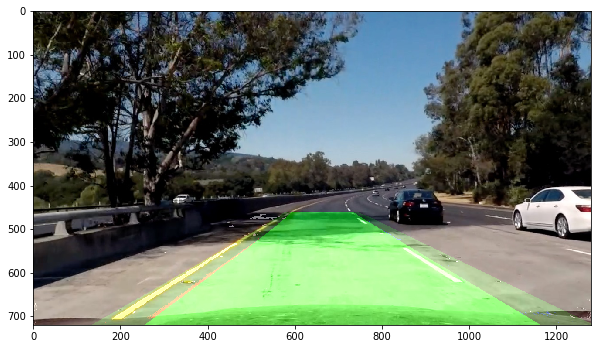

<test6.jpg>
fitXY - left fit: [  1.92847559e-04  -4.11714177e-01   5.06019117e+02]
fitXY - right fit: [  3.45062489e-04  -4.57114193e-01   1.24853377e+03]
fitXY - left fit: [  1.78163978e-04  -3.98428205e-01   5.03143898e+02]
fitXY - right fit: [  2.96897770e-04  -4.31210528e-01   1.24631888e+03]
Curvature result
922.223046329 m 553.142581598 m


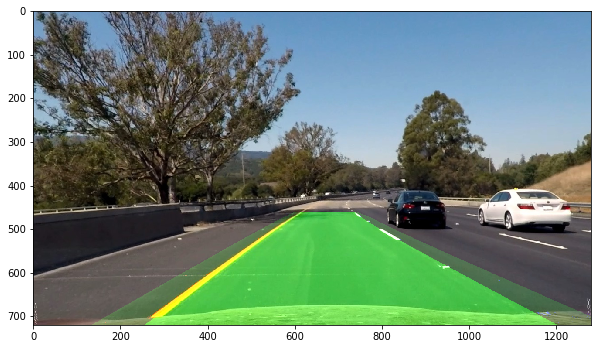

In [169]:
result_marking_images = []

#for idx, (f, im,original_im) in enumerate(zip(filenames,binary_lane_images,images)):
for idx, (f, original_im) in enumerate(zip(filenames, images)):
    
    undist_image = undist_ops(original_im)
    img = makeWarpViewBinaryImage(original_im,src,dst,mtx,dist)
    
    
    out_img,midpoint,leftx_base,rightx_base,leftx,lefty,rightx,righty = searchinglaneline(img)
    ploty = np.linspace(0, im.shape[0]-1, im.shape[0] )

    print("<%s>" % f)
    
    #
    #  highlight and plot found lane line dot. 
    #
    out_img[lefty,leftx] = [255,0,0] # LEFT RED
    out_img[righty,rightx] = [0,0,255] # RIGHT BLUE
    result_marking_images.append(out_img)
    
    # fitting to get a * y^2 + b * y + c
    # get coefficient for formula from searched scattered point (x y)
    left_fit,right_fit = fitting(lefty,leftx,righty,rightx)
    
    # one solid line based on fitted parameters and Y (0-720)
    # line should be displayed on Yellow
    # based coefficient and ploty, curved line is generated
    # left_fitx / right_fitx are x value on generated left and right curved lines.
    left_fitx,right_fitx = fitXY(ploty,left_fit,right_fit)
    
    #displyIntegrateView(out_img,ploty,left_fitx,right_fitx)
    #
    # after finding lane line, following process should be called.
    # 
    # left_fitx / right_fitx are generated result plot value based on fitting (polyfit)
    result, left_fitx, right_fitx = genResultImageAfterFitting(img, ploty, left_fit,right_fit)
    curvature(ploty, left_fitx, right_fitx)
    drawPolygonZoneOnLane(undist_image, result, ploty, left_fitx, right_fitx, Minv)
    

In [160]:
class LaneDetector():
    
    def __init__(self,src,dst,mtx,dist):
        
        self.src = src
        self.dst = dst
        self.mtx = mtx
        self.dist = dist
    
    def check(self,original_image):

        im = makeWarpViewBinaryImage(original_image,self.src,self.dst,self.mtx,self.dist)
        plt.imshow(im)
        plt.show()

    def singleImagePipeline(self,original_image):

        undist_image = undist_ops(original_image)
        im = makeWarpViewBinaryImage(original_image,self.src,self.dst,self.mtx,self.dist)

        out_img,midpoint,leftx_base,rightx_base,leftx,lefty,rightx,righty = searchinglaneline(im)
        ploty = np.linspace(0, im.shape[0]-1, im.shape[0] )

        #
        #  highlight and plot found lane line dot. 
        #
        out_img[lefty,leftx] = [255,0,0] # LEFT RED
        out_img[righty,rightx] = [0,0,255] # RIGHT BLUE
        result_marking_images.append(out_img)

        # fitting to get a * y^2 + b * y + c
        # get coefficient for formula from searched scattered point (x y)
        left_fit,right_fit = fitting(lefty,leftx,righty,rightx)

        # one solid line based on fitted parameters and Y (0-720)
        # line should be displayed on Yellow
        # based coefficient and ploty, curved line is generated
        # left_fitx / right_fitx are x value on generated left and right curved lines.
        left_fitx,right_fitx = fitXY(ploty,left_fit,right_fit)

        #displyIntegrateView(out_img,ploty,left_fitx,right_fitx)
        #
        # after finding lane line, following process should be called.
        # 
        # left_fitx / right_fitx are generated result plot value based on fitting (polyfit)
        result, left_fitx, right_fitx = genResultImageAfterFitting(im, ploty, left_fit,right_fit)
        curvature(ploty, left_fitx, right_fitx)
        drawPolygonZoneOnLane(undist_image, result, ploty, left_fitx, right_fitx, Minv)
    

fitXY - left fit: [  1.26428159e-04  -1.09194161e-01   2.99670502e+02]
fitXY - right fit: [  1.46130834e-05  -7.56672855e-02   1.05492452e+03]
fitXY - left fit: [  1.76027192e-04  -3.92387882e-01   4.99967058e+02]
fitXY - right fit: [ -6.78632448e-04   4.56878227e-01   1.04327458e+03]
Curvature result
933.39905068 m 243.571741707 m


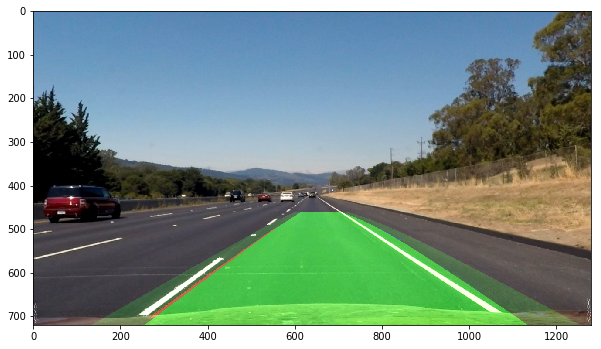

In [165]:
lane = LaneDetector(src,dst,mtx,dist)
lane.singleImagePipeline(images[1])

# Video Clip 

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip

In [ ]:
in_file = "project_video.mp4"
out_file = os.path.join("output_images",in_file)

print('Processing video ...')
clip2 = VideoFileClip(in_file)
vid_clip = clip2.fl_image(process_image)
vid_clip.write_videofile(out_file, audio=False)

In [ ]:
class LaneTracker:

    def __init__(self, mtx, dist):
        # matrix from calibrating camera
        self.mtx = mtx
        # distortion coefficients from calibrating camera
        self.dist = dist
        # was the line detected in the last iteration?
        self.detected = False
        # x values of the last n fits of the left line
        self.recent_left_xfitted = []
        # x values of the last n fits of the right line
        self.recent_right_xfitted = []
        # polynomial coefficients for left averaged over the last n iterations
        self.best_left_fit = None
        # polynomial coefficients for right averaged over the last n iterations
        self.best_right_fit = None
        # polynomial coefficients for the most recent left fit
        self.current_left_fit = [np.array([False])]
        # polynomial coefficients for the most recent right fit
        self.current_right_fit = [np.array([False])]
        # radius of curvature of the line in some units
        self.radius_of_curvature = None
        # distance in meters of vehicle center from the line
        self.line_base_pos = None


    def apply_lines(self, img):
        # Undistort the image
        img = cv2.undistort(img, self.mtx, self.dist, None, self.mtx)

        # Threshold gradient
        #grad_binary = np.zeros_like(img[:,:,0])
        #mag_binary = mag_thresh(img, sobel_kernel=9, thresh=(50, 255))
        #dir_binary = dir_thresh(img, sobel_kernel=15, thresh=(0.7, 1.3))
        #grad_binary[((mag_binary == 1) & (dir_binary == 1))] = 1

        # Threshold color
        #color_binary = color_thresh(img, r_thresh=(220, 255), s_thresh=(150, 255))

        # Combine gradient and color thresholds
        #combo_binary = np.zeros_like(img[:,:,0])
        #combo_binary[(grad_binary == 1) | (color_binary == 1)] = 255
        
        pipelineBinaryImage4

        # Define perspective transform area
        img_size = (img.shape[1], img.shape[0])
        src = np.float32(
            [[(img_size[0] / 2) - 55, img_size[1]/2 + 100],
            [((img_size[0] / 6) - 10), img_size[1]],
            [(img_size[0] * 5 / 6) + 60, img_size[1]],
            [(img_size[0] / 2 + 55), img_size[1]/2 + 100]])
        dst = np.float32(
            [[(img_size[0] / 4), 0],
            [(img_size[0] / 4), img_size[1]],
            [(img_size[0] * 3 / 4), img_size[1]],
            [(img_size[0] * 3 / 4), 0]])

        # Perform the transform
        M = cv2.getPerspectiveTransform(src, dst)
        Minv = cv2.getPerspectiveTransform(dst, src)
        warped_binary = cv2.warpPerspective(combo_binary, M, img_size, flags=cv2.INTER_LINEAR)
        
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = warped_binary.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Create empty lists to receive left and right lane pixel indices
        left_lane_idx = []
        right_lane_idx = []

        # Set the width of the windows +/- margin
        margin = 100
        # Only search the entire image if lines have not been previously detected
        if self.detected == False:
            # Take a histogram of the bottom half of the image
            histogram = np.sum(warped_binary[int(warped_binary.shape[0]/2):,:], axis=0)
            # Find the peak of the left and right halves of the histogram
            # These will be the starting point for the left and right lines
            midpoint = np.int(histogram.shape[0]/2)
            leftx_base = np.argmax(histogram[:midpoint])
            rightx_base = np.argmax(histogram[midpoint:]) + midpoint

            # Current positions to be updated for each window
            leftx_current = leftx_base
            rightx_current = rightx_base

            # Choose the number of sliding windows
            nwindows = 9
            # Set height of windows
            window_height = np.int(warped_binary.shape[0]/nwindows)

            # Set minimum number of pixels found to recenter window
            minpix = 50

            # Step through the windows one by one
            for window in range(nwindows):
                # Identify window boundaries in x and y (and right and left)
                win_y_low = warped_binary.shape[0] - (window+1)*window_height
                win_y_high = warped_binary.shape[0] - window*window_height
                win_xleft_low = leftx_current - margin
                win_xleft_high = leftx_current + margin
                win_xright_low = rightx_current - margin
                win_xright_high = rightx_current + margin
                # Identify the nonzero pixels in x and y within the window
                good_left_idx = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
                good_right_idx = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
                # Append these indices to the lists
                left_lane_idx.append(good_left_idx)
                right_lane_idx.append(good_right_idx)
                # If you found > minpix pixels, recenter next window on their mean position
                if len(good_left_idx) > minpix:
                    leftx_current = np.int(np.mean(nonzerox[good_left_idx]))
                if len(good_right_idx) > minpix:
                    rightx_current = np.int(np.mean(nonzerox[good_right_idx]))

            # Concatenate the arrays of indices
            left_lane_idx = np.concatenate(left_lane_idx)
            right_lane_idx = np.concatenate(right_lane_idx)
            self.detected = True

        else:
            left_lane_idx = ((nonzerox > (self.best_left_fit[0]*(nonzeroy**2) + self.best_left_fit[1]*nonzeroy \
                            + self.best_left_fit[2] - margin)) & (nonzerox < (self.best_left_fit[0]*(nonzeroy**2) \
                            + self.best_left_fit[1]*nonzeroy + self.best_left_fit[2] + margin)))
            right_lane_idx = ((nonzerox > (self.best_right_fit[0]*(nonzeroy**2) + self.best_right_fit[1]*nonzeroy \
                            + self.best_right_fit[2] - margin)) & (nonzerox < (self.best_right_fit[0]*(nonzeroy**2) \
                            + self.best_right_fit[1]*nonzeroy + self.best_right_fit[2] + margin)))

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_idx]
        lefty = nonzeroy[left_lane_idx]
        rightx = nonzerox[right_lane_idx]
        righty = nonzeroy[right_lane_idx]

        # polynomial coefficients for the most recent fit
        self.current_left_fit = np.polyfit(lefty, leftx, 2)
        self.current_right_fit = np.polyfit(righty, rightx, 2)

        # x values of the last n fits of the left line
        self.recent_left_xfitted.append(self.current_left_fit)
        # x values of the last n fits of the right line
        self.recent_right_xfitted.append(self.current_right_fit)

        self.best_left_fit = np.mean(self.recent_left_xfitted[-min(15,len(self.recent_left_xfitted)):], axis=0)
        self.best_right_fit = np.mean(self.recent_right_xfitted[-min(15,len(self.recent_right_xfitted)):], axis=0)

        # Generate x and y values for plotting
        ploty = np.linspace(0, warped_binary.shape[0]-1, warped_binary.shape[0])
        left_fitx = self.best_left_fit[0]*ploty**2 + self.best_left_fit[1]*ploty + self.best_left_fit[2]
        right_fitx = self.best_right_fit[0]*ploty**2 + self.best_right_fit[1]*ploty + self.best_right_fit[2]

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Create an image to draw the lines
        warp_zero = np.zeros_like(warped_binary[:-20]).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255,0))

        # Warp the blank back to original image space using inverse perspective matrix
        unwarped = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0]))

        # Combine the result with the original undistorted image
        result = cv2.addWeighted(img, 1, unwarped, 0.3, 0)

        # Compute the raduis of curvature of lane
        # Measure radius of curvature at y-value closest to car
        y_eval = np.max(ploty)

        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720
        xm_per_pix = 3.7/700

        # Fit polynomials to x,y in world space
        left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
        # Calculate radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        self.radius_of_curvature = (left_curverad+right_curverad)/2

        # Calculate offset of the car between the lane
        camera_center = (left_fitx[-1] + right_fitx[-1])/2
        self.line_base_pos = (camera_center-unwarped.shape[1]/2)*xm_per_pix
        side_pos = 'left'
        if self.line_base_pos <= 0:
            side_pos = 'right'

        # draw the text showing curvature, offset, and speed
        cv2.putText(result, 'Radius of curvature = ' + str(round(self.radius_of_curvature, 3))+' (m)',(50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255),2)
        cv2.putText(result,'Vehicle is '+str(abs(round(self.line_base_pos,3)))+'m '+side_pos+' of center',(50,100), cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)

return result

In [ ]:
# Define a class to receive the characteristics of each line detection 
class Line(): 
    def __init__(self): 
        # flag for new line 
        self.new_line = True 
        # was the line detected in the last iteration? 
        self.non_detect_tally = 0 
        self.non_detect_tally_max = 5 
        self.detected = False # x values of the last n fits of the line 
        self.recent_xfitted = [] #average x values of the fitted line over the last n iterations 
        self.bestx = None #polynomial coefficients averaged over the last n iterations 
        self.best_fit = None 
        #polynomial coefficients for the most recent fit 
        self.current_fit = [np.array([False])] 
        #radius of curvature of the line in some units 
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line 
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits 
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels 
        self.allx = None 
        #y values for detected line pixels 
        self.ally = None 
        self.ploty = [] 
        # camera parameters 
        self.dst = np.loadtxt('cam_dist.txt') 
        self.mtx = np.loadtxt('cam_mtx.txt') 
        # 
        #self.src_points = np.float32([[281,674], 
                                      # 
        #                              [587,455], 
                                      # 
        #                              [697,455], 
                                      # 
        #                              [1040,674]]) 
        # 
        #self.dst_points = np.float32([[281,674], 
                                      # 
        #                              [281,0], 
                                      # 
        #                              [1040,0], 
                                      # 
        #                              [1040,674]]) 
        self.src_points = np.float32([[270,674], [587,455], [694,455], [1035,674]]) 
        self.dst_points = np.float32([[270,674], [270,0], [1035,0], [1035,674]]) 
        
        self.M = np.loadtxt('M_mat.txt') 
        self.Minv = np.loadtxt('Minv_mat.txt') 
        # windows 
        # Set the width of the windows +/- margin 
        self.margin = 50 # Set minimum number of pixels found to recenter window 
        self.minpix = 100 
        # Conversions in x and y from pixels space to meters 
        self.ym_per_pix = 30/720.0 
        # meters per pixel in y dimension 
        self.xm_per_pix = 3.7/700.0 
        # meters per pixel in x dimension 
    def thresh_bin_im(self, image, s_thresh=(150, 255), sxl_thresh=(15, 255), sxr_thresh=(20, 255), kernel=3): 
        """ Return the colour thresholds binary for L, S and R channels in an image img: 
        RGB image s_thresh: S channel threshold sxl_thresh: 
        sobel x threshold for L channel sxr_thresh: sobel x threshold for R channel """ 
        def bin_it(image, threshold): 
            output_bin = np.zeros_like(image) output_bin[(image >= threshold[0]) & (image <= threshold[1])]=1 
            return output_bin 
        hls_im = cv2.cvtColor(image, cv2.COLOR_RGB2HLS) 
        bin_thresh = [10, 255] 
        # rgb threshold for yellow 
        lower = np.array([230,180,20],dtype = "uint8") 
        upper = np.array([255, 255, 255],dtype = "uint8") 
        mask = cv2.inRange(image, lower, upper) 
        rgb_y = cv2.bitwise_and(image, image, mask = mask).astype(np.uint8) 
        rgb_y = cv2.cvtColor(rgb_y, cv2.COLOR_RGB2GRAY) 
        rgb_y = bin_it(rgb_y, bin_thresh) 
        # rgb for white (best) 
        lower = np.array([100,100,200],dtype = "uint8") 
        upper = np.array([255, 255, 255],dtype = "uint8") 
        mask = cv2.inRange(image, lower, upper) 
        rgb_w = cv2.bitwise_and(image, image, mask = mask).astype(np.uint8) 
        rgb_w = cv2.cvtColor(rgb_w, cv2.COLOR_RGB2GRAY) 
        rgb_w = bin_it(rgb_w, bin_thresh) 
        # hls yellow 
        lower = np.array([20,50,30],dtype = "uint8") 
        upper = np.array([45, 200, 255],dtype = "uint8") 
        mask = cv2.inRange(hls_im, lower, upper) 
        hls_y = cv2.bitwise_and(hls_im, hls_im, mask = mask).astype(np.uint8) 
        # 
        hls_y = cv2.cvtColor(hls_y, cv2.COLOR_HLS2BGR) 
        hls_y = cv2.cvtColor(hls_y, cv2.COLOR_RGB2GRAY) 
        hls_y = bin_it(hls_y, bin_thresh) 
        im_bin = np.zeros_like(rgb_y).astype(np.uint8) 
        im_bin [(hls_y == 1)|(rgb_w==1)|(rgb_y==1)]= 1 
        return im_bin 
    
    def bin_image(self, image): 
        """ convert colour binary image into a single channel binary image image: 
        array with 3 channels return binary image with 1 channel 
        which is a bitwise or operation of the original colour channels """ 
        binary = np.zeros_like(image[:,:,1]) 
        binary[(image[:,:,0] == 1) | (image[:,:,1]==1) |(image[:,:,2]==1)] = 1 
        return binary
    
    def transform_n_warp(self, image, M):
        """ apply transforms to image and warp the image according to transformation matrix image: 
        image to be transformed M: transformation matrix """ 
        # image size 
        img_size = image.shape[:2][::-1] 
        # warp image 
        image = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR) 
        # convert to coloured binary image 
        image = self.thresh_bin_im(image, s_thresh=(150, 255), sxl_thresh=(15, 255), sxr_thresh=(20, 255), kernel=3) 
        return image
    
    def update_fit(self, left_fit, right_fit, patience=6): 
        """ update the fit values for n iterations """ 
        self.current_fit = [left_fit, right_fit] 
        self.recent_xfitted.append(self.current_fit) 
        if len(self.recent_xfitted) > patience: 
            self.recent_xfitted.pop(0) 
            # calculate best fit, mean of last n iterations determined by patience 
            self.best_fit = np.mean(self.recent_xfitted, axis=0) 
            return self.best_fit 
        
    # find lane function, with sliding window approach 
    def find_lane(self, warped): 
        """ return image with lane lines using sliding window approach warped: 
        image in bird's eye view """ 
        # check if there is a previous line 
        if self.detected: 
            # 
            self.new_line = False 
            # Set the width of the windows +/- margin 
            margin = self.margin 
            # Set minimum number of pixels found to recenter window 
            minpix = self.minpix 
            # Create an output image to draw on and visualize the result 
            out_img = np.dstack((warped, warped, warped)).astype(np.int8)#*255 
            window_img = np.zeros_like(out_img) if self.new_line or self.non_detect_tally